In [11]:
import matplotlib.pyplot as plt
import time
import serial
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from scipy.optimize import curve_fit

file_count = input("測定回数を入力してください(例:1): ")
measurement_kind = input("測定するマッキベンの種類を入力してください(4s or 4l or 6 or s or u): ")
pressure = input("圧力を入力してください(例:4): ")

pressure = f"0.{pressure}"  

start_time = 10
end_time = 14.4

測定回数を入力してください(例:1):  2
測定するマッキベンの種類を入力してください(4s or 4l or 6 or s or u):  6
圧力を入力してください(例:4):  6


In [12]:
date = input("推定パラメータの日付を入力してください: ")
count = input("推定パラメータの測定回数を入力してください: ")  

推定パラメータの日付を入力してください:  20231124
推定パラメータの測定回数を入力してください:  1


In [19]:
# com8 からの圧力データを取得する設定
com8 = serial.Serial("COM16", 115200)
# com15 からのセンサーデータを取得する設定
com15 = serial.Serial('COM13', 115200, timeout=1)

path = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\input\\'
path2 = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\output\\'

file_name_all_com8 = f"{datetime.now().strftime('%Y%m%d')}_{file_count}_{measurement_kind}_{pressure}_all_p_input"
file_name_partial_com8 = f"{datetime.now().strftime('%Y%m%d')}_{file_count}_{measurement_kind}_{pressure}_partial_p_input"
date_com8 = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

file_name_all_com15 = f"{datetime.now().strftime('%Y%m%d')}_{file_count}_{measurement_kind}_{pressure}_all_p_output"
file_name_partial_com15 = f"{datetime.now().strftime('%Y%m%d')}_{file_count}_{measurement_kind}_{pressure}_partial_p_output"
date_com15 = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print('start!')

t0_com8 = time.time()
t0_com15 = time.time()

# データを保存するリスト
all_time_vals_com8 = []
all_p_vals_com8 = []
partial_time_vals_com8 = []
partial_p_vals_com8 = []
partial_start_time_com8 = None

all_time_vals_com15 = []
all_length_vals_com15 = []  
all_p_vals_com15 = []
all_force_vals_com15 = []
partial_time_vals_com15 = []
partial_length_vals_com15 = []  
partial_p_vals_com15 = []
partial_force_vals_com15 = []
partial_start_time_com15 = None

with open(path + file_name_all_com8 + ".csv", "a", encoding='cp1252') as all_f_com8, \
        open(path + file_name_partial_com8 + ".csv", "a", encoding='cp1252') as partial_f_com8, \
        open(path2 + file_name_all_com15 + ".csv", "a", encoding='cp1252') as all_f_com15, \
        open(path2 + file_name_partial_com15 + ".csv", "a", encoding='cp1252') as partial_f_com15:

    
    # ヘッダーをファイルに書き込む
    if all_f_com8.tell() == 0:  # ファイルが空の場合だけヘッダーを書き込む
        print("time,p,voltage", file=all_f_com8)
    
    if partial_f_com8.tell() == 0:  # ファイルが空の場合だけヘッダーを書き込む
        print("time,p,voltage", file=partial_f_com8)
    
    if all_f_com15.tell() == 0:  # ファイルが空の場合だけヘッダーを書き込む
        print("time,length,pressure,force", file=all_f_com15)
    
    if partial_f_com15.tell() == 0:  # ファイルが空の場合だけヘッダーを書き込む
        print("time,length,pressure,force", file=partial_f_com15)
        
    try:
        while True:
            # com8 からのデータ処理
            t_com8 = time.time()
            t_inner_com8 = t_com8 - t0_com8
            if t_inner_com8 > 15:
                print("saved as " + file_name_all_com8 + ".csv" + "!")
                break

            data_com8 = com8.readline().decode().strip()
            current_time_com8 = time.time()
            elapsed_time_com8 = round((current_time_com8 - t0_com8), 3)  # 四捨五入して小数点以下第三位まで

            print(f"{elapsed_time_com8} - {data_com8}")

            if data_com8 and not data_com8.startswith("Sensor reading stopped"):
                parts_com8 = data_com8.split(',')
                if len(parts_com8) == 3:
                    wire_length, p_val_com8, force = parts_com8
                    p_val_com8 = float(p_val_com8) / 10.0  # bar から MPa への変換

                    if all_time_vals_com8 and elapsed_time_com8 <= all_time_vals_com8[-1]:
                        break

                    all_time_vals_com8.append(elapsed_time_com8)
                    all_p_vals_com8.append(p_val_com8)

                    print("{},{},{}".format(elapsed_time_com8, p_val_com8, force), file=all_f_com8)

                    if t_inner_com8 >= start_time and t_inner_com8 <= end_time:
                        if partial_start_time_com8 is None or elapsed_time_com8 <= partial_start_time_com8:
                            partial_start_time_com8 = elapsed_time_com8
                        partial_time_vals_com8.append(elapsed_time_com8 - partial_start_time_com8)
                        partial_p_vals_com8.append(p_val_com8)

                        print("{},{},{}".format(elapsed_time_com8, p_val_com8, force), file=partial_f_com8)
                else:
                    print("Invalid data format:", data_com8)
            elif data_com8.startswith("Sensor reading stopped"):
                print("Sensor reading stopped. Exiting loop.")
                break

            # com15 からのデータ処理
            t_com15 = time.time()
            t_inner_com15 = t_com15 - t0_com15
            if t_inner_com15 > 15:
                print("saved as " + file_name_all_com15 + ".csv" + "!")
                break

            data_com15 = com15.readline().decode().strip()
            current_time_com15 = time.time()
            elapsed_time_com15 = round((current_time_com15 - t0_com15), 3)  # 四捨五入して小数点以下第三位まで

            print(f"{elapsed_time_com15} - {data_com15}")

            if data_com15 and not data_com15.startswith("Sensor reading stopped"):
                parts_com15 = data_com15.split(',')
                if len(parts_com15) == 3:
                    wire_length, p_val_com15, force = parts_com15
                    p_val_com15 = float(p_val_com15) / 1000.0  

                    if all_time_vals_com15 and elapsed_time_com15 <= all_time_vals_com15[-1]:
                        break

                    all_time_vals_com15.append(elapsed_time_com15)
                    if wire_length:
                        all_length_vals_com15.append(float(wire_length))  
                    all_p_vals_com15.append(p_val_com15)
                    if force:
                        all_force_vals_com15.append(float(force))  

                    print("{},{},{},{}".format(elapsed_time_com15, wire_length, p_val_com15, force), file=all_f_com15)

                    if t_inner_com15 >= start_time and t_inner_com15 <= end_time:
                        if partial_start_time_com15 is None or elapsed_time_com15 <= partial_start_time_com15:
                            partial_start_time_com15 = elapsed_time_com15
                        partial_time_vals_com15.append(elapsed_time_com15 - partial_start_time_com15)
                        partial_length_vals_com15.append(float(wire_length))  
                        partial_p_vals_com15.append(p_val_com15)
                        partial_force_vals_com15.append(float(force))
                        #time_elapsed = elapsed_time_com15 - partial_start_time_com15

                        print("{},{},{},{}".format(elapsed_time_com15 - partial_start_time_com15, wire_length, p_val_com15, force,), file=partial_f_com15)
                else:
                    print("Invalid data format:", data_com15)
            elif data_com15.startswith("Sensor reading stopped"):
                print("Sensor reading stopped. Exiting loop.")
                break


    except KeyboardInterrupt:
        print("Interrupt received. Saving CSV files and exiting.")

    finally:
        com8.close()
        com15.close()


start!
3.911 - 3.00,-0.03,10.00
3.92 - 00
Invalid data format: 00
3.921 - 3.01,-0.03,-2.61
3.921 - 263.40,2,43.50
3.943 - 3.02,-0.03,-2.39
3.944 - 263.50,0,44.50
3.955 - 3.04,-0.02,-2.18
3.956 - 263.50,0,44.90
3.964 - 3.05,-0.03,-1.87
3.965 - 263.50,0,44.50
3.976 - 3.06,-0.03,-1.75
3.976 - 263.50,0,44.30
3.984 - 3.07,-0.03,-1.54
3.989 - 263.50,0,44.20
3.996 - 3.09,-0.03,-1.32
3.996 - 263.50,0,44.20
4.012 - 3.10,-0.03,-1.12
4.012 - 263.50,0,44.00
4.023 - 3.11,-0.03,-0.93
4.023 - 263.50,-1,44.00
4.033 - 3.12,-0.03,-0.74
4.033 - 263.50,-1,44.00
4.05 - 3.13,-0.03,-0.53
4.051 - 263.50,-1,44.00
4.063 - 3.14,-0.03,-0.34
4.064 - 263.50,-1,44.00
4.075 - 3.16,-0.03,-0.16
4.076 - 263.50,0,43.90
4.084 - 3.17,-0.03,0.02
4.088 - 263.50,-1,44.00
4.095 - 3.18,1.06,0.22
4.095 - 263.50,-1,43.90
4.113 - 3.19,1.70,6.93
4.115 - 263.50,-1,44.00
4.123 - 3.21,1.29,10.97
4.124 - 263.50,-1,43.90
4.135 - 3.22,1.04,8.67
4.135 - 263.50,-1,43.90
4.143 - 3.23,0.88,7.37
4.144 - 263.50,0,43.90
4.156 - 3.24,0.84,6.59
4

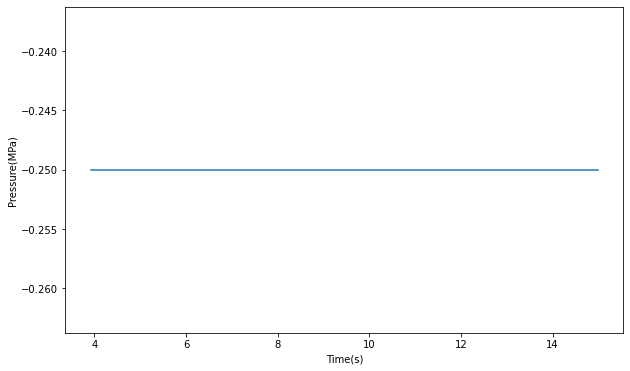

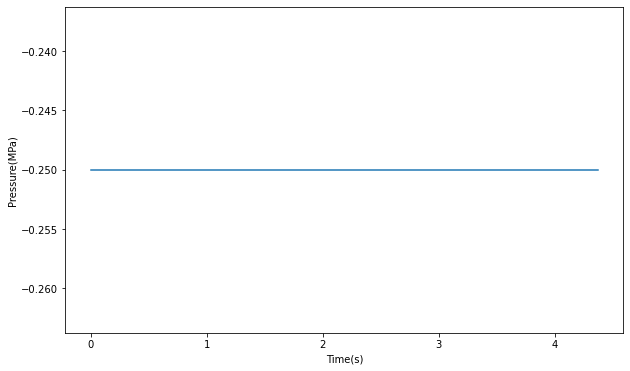

<Figure size 432x288 with 0 Axes>

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\output\\20231206_test_6_0.6_partial_p_output.csv'

In [7]:
# グラフの描画
# com8 からのデータのグラフの描画
plt.figure(figsize=(10,6))
plt.plot(all_time_vals_com8, all_p_vals_com8)
plt.xlabel('Time(s)')
plt.ylabel('Pressure(MPa)')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(partial_time_vals_com8, partial_p_vals_com8)
plt.xlabel('Time(s)')
plt.ylabel('Pressure(MPa)')
plt.show()

# グラフを保存
save_path_com8 = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\graph\\pressure_control\\input\\'
plt.savefig(save_path_com8 + file_name_all_com8 + '.jpg')
plt.savefig(save_path_com8 + file_name_partial_com8 + '.jpg')

# グラフの表示
plt.show()

# 以下Lのフィッティング
csv_file_path = f'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\estimated_parameter_length\\L_fit_{date}_{count}_{measurement_kind}_epl.csv'
parameters = pd.read_csv(csv_file_path)

# パラメータの値を取得
c3_e = parameters.loc[parameters['Parameter'] == 'c3_e', 'Value'].values[0]
c2_e = parameters.loc[parameters['Parameter'] == 'c2_e', 'Value'].values[0]
c1_e = parameters.loc[parameters['Parameter'] == 'c1_e', 'Value'].values[0]
c0_e = parameters.loc[parameters['Parameter'] == 'c0_e', 'Value'].values[0]

c3_c = parameters.loc[parameters['Parameter'] == 'c3_c', 'Value'].values[0]
c2_c = parameters.loc[parameters['Parameter'] == 'c2_c', 'Value'].values[0]
c1_c = parameters.loc[parameters['Parameter'] == 'c1_c', 'Value'].values[0]
c0_c = parameters.loc[parameters['Parameter'] == 'c0_c', 'Value'].values[0]


# CSVファイルの読み込み
dt = pd.read_csv(
    f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\output\\{datetime.now().strftime('%Y%m%d')}_{file_count}_{measurement_kind}_{pressure}_partial_p_output.csv",
    #on_bad_lines='skip'
)

# dt DataFrameのtime列を確認
# dt['time'] = pd.to_numeric(dt['time'], errors='coerce')
# time_column = dt['time']

# # time列の値が減少したらそれ以降の行を削除
# for i in range(1, len(time_column)):
#     if time_column.iloc[i] < time_column.iloc[i-1]:
#         dt = dt.iloc[:i]
#         break

# # 保存するファイルのパス
# output_csv_path = f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\output\\{datetime.now().strftime('%Y%m%d')}_{file_count}_{measurement_kind}_{pressure}_partial_p_output.csv"

# # 新しい列が追加されたDataFrameをCSVファイルとして保存
# dt.to_csv(output_csv_path, index=False)


column = dt[["time", "length", "pressure", "force"]]

time_values = partial_time_vals_com15
pressure_values = column["pressure"].values
length_values = column["length"].values
force_values = column["force"].values

# pressureが最大値を取るまでの範囲
idx_max_pressure = column["pressure"].idxmax()
column['time_contraction'] = np.nan  # 新しい列を追加
column['time_contraction'].iloc[:idx_max_pressure + 1] = time_values[:idx_max_pressure + 1]
column['pressure_contraction'] = np.nan  # 新しい列を追加
column['pressure_contraction'].iloc[:idx_max_pressure + 1] = pressure_values[:idx_max_pressure + 1]
column['length_contraction'] = np.nan  # 新しい列を追加
column['length_contraction'].iloc[:idx_max_pressure + 1] = length_values[:idx_max_pressure + 1]
column['force_contraction'] = np.nan  # 新しい列を追加
column['force_contraction'].iloc[:idx_max_pressure + 1] = force_values[:idx_max_pressure + 1]

# pressureが最大値を取った後の範囲
column['time_extension'] = np.nan  # 新しい列を追加
column['time_extension'].iloc[idx_max_pressure + 1:] = time_values[idx_max_pressure + 1:]
column['pressure_extension'] = np.nan  # 新しい列を追加
column['pressure_extension'].iloc[idx_max_pressure + 1:] = pressure_values[idx_max_pressure + 1:]
column['length_extension'] = np.nan  # 新しい列を追加
column['length_extension'].iloc[idx_max_pressure + 1:] = length_values[idx_max_pressure + 1:]
column['force_extension'] = np.nan  # 新しい列を追加
column['force_extension'].iloc[idx_max_pressure + 1:] = force_values[idx_max_pressure + 1:]


# 新しい列の計算
gap = 13  # 静的テストと動的テストで，リニアエンコーダを固定する場所が異なるので，その分の差をこれで埋める

# 新しい列の計算
column['estimated_contraction_length'] = column.apply(
    lambda row: calculate_L((row['pressure_contraction'] + gap, row['force_contraction']), c3_c, c2_c, c1_c, c0_c),
    axis=1
)

column['estimated_extension_length'] = column.apply(
    lambda row: calculate_L((row['pressure_extension'] + gap, row['force_extension']), c3_e, c2_e, c1_e, c0_e),
    axis=1
)

# 保存するファイルのパス
output_csv_path = f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\output\\{datetime.now().strftime('%Y%m%d')}_{file_count}_{measurement_kind}_{pressure}_partial_p_output.csv"
column.to_csv(output_csv_path, index=False)


# センサー値グラフ
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.plot(partial_time_vals_com15, partial_force_vals_com15, color='brown')
plt.xlabel('Time(s)')
plt.ylabel('Force(N)')

plt.subplot(3, 1, 2)
plt.plot(partial_time_vals_com15, partial_p_vals_com15, color='brown')
plt.xlabel('Time(s)')
plt.ylabel('Pressure(MPa)')

plt.subplot(3, 1, 3)
# ここに推定されたLを点線で追加する．
plt.plot(partial_time_vals_com15, partial_length_vals_com15,color='brown')
plt.plot(column['time_contraction'], column["estimated_contraction_length"], '--', color='green')
plt.plot(column['time_extension'], column["estimated_extension_length"], '--', color='green')
plt.xlabel('Time(s)')
plt.ylabel('Length(mm)')

# グラフを保存
save_path_com15 = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\graph\\pressure_control\\output\\'
plt.savefig(save_path_com15 + file_name_partial_com15 + '.jpg')

# グラフを表示
plt.show()
